# Deep Learning Small Project

* He Yuhang 1003775
* Zhang Jiazheng 1003772
* Zhang Shaozuo 1003756



In [1]:
# Import libraries
import importlib

import matplotlib.pyplot as plt
import torch
import torchsummary
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import utils.data as data_utils
import utils.model as model_utils
import utils.train as utils

# Reload utils after editing
importlib.reload(data_utils)
importlib.reload(model_utils)
importlib.reload(utils)
pass

In [2]:
# Define constants
dataset_path = './dataset'
batch_size = 64
device = 'cuda'


## Dataset

In [3]:
# Define data loaders
dataset_groups = ('train', 'test', 'val')
dataset_types = {
    '3-classes': ('normal', 'non-covid', 'covid'),
    'infected':  ('normal', 'infected'),
    'covid':     ('non-covid', 'covid')
}

lung_datasets = {}
for name, classes in dataset_types.items():
    lung_datasets[name] = {}
    for group in dataset_groups:
        lung_datasets[name][group] = data_utils.LungDataset(dataset_path, group, classes)

lung_loaders = {}
for name, sub_sets in lung_datasets.items():
    sub_loader = {}
    for type, dataset in sub_sets.items():
        sub_loader[type] = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    lung_loaders[name] = sub_loader


tensor([1, 0, 1, 2])
{'normal': 0, 'non-covid': 1, 'covid': 2}


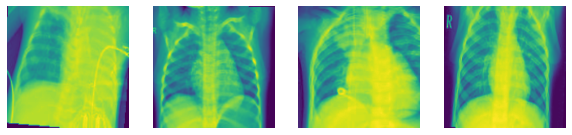

In [4]:
# Check images loaded
images, labels = next(iter(lung_loaders['3-classes']['train']))
fig, axes = plt.subplots(figsize=(10, 4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    utils.imshow(images[ii], ax=ax)
print(labels[:4])
print(lung_datasets['3-classes']['train'].class_to_idx)

## Model
### Infected vs. Normal

In [5]:
# Define infected vs. normal model
model_infected = model_utils.NetInfected().to(device)
torchsummary.summary(model_infected, (batch_size, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 150, 150]               2
            Conv2d-2         [-1, 24, 148, 148]             240
            Conv2d-3           [-1, 32, 72, 72]           6,944
            Conv2d-4           [-1, 64, 34, 34]          18,496
            Conv2d-5           [-1, 64, 15, 15]          36,928
            Conv2d-6            [-1, 128, 5, 5]          73,856
           Dropout-7            [-1, 128, 2, 2]               0
            Linear-8                  [-1, 128]          65,664
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 1]             129
Total params: 202,259
Trainable params: 202,259
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.49
Forward/backward pass size (MB): 6.15
Params size (MB): 0.77
Estimated T

Epoch: 1/35 @ 2021-03-21 14:21:36.952632
82/82 [==============================] - 10s 121ms/step - loss: 0.554 - accuracy: 0.746 - val_loss: 0.557 - val_accuracy: 0.759 - saved to checkpoints\2021-03-21_14-21\ckpt_00.pth
Epoch: 2/35 @ 2021-03-21 14:21:46.838619
82/82 [==============================] - 10s 116ms/step - loss: 0.374 - accuracy: 0.822 - val_loss: 0.374 - val_accuracy: 0.841 - saved to checkpoints\2021-03-21_14-21\ckpt_01.pth
Epoch: 3/35 @ 2021-03-21 14:21:56.384619
82/82 [==============================] - 10s 116ms/step - loss: 0.279 - accuracy: 0.874 - val_loss: 0.282 - val_accuracy: 0.893 - saved to checkpoints\2021-03-21_14-21\ckpt_02.pth
Epoch: 4/35 @ 2021-03-21 14:22:05.917620
82/82 [==============================] - 9s 114ms/step - loss: 0.217 - accuracy: 0.912 - val_loss: 0.288 - val_accuracy: 0.894 - saved to checkpoints\2021-03-21_14-21\ckpt_03.pth
Epoch: 5/35 @ 2021-03-21 14:22:15.289623
82/82 [==============================] - 10s 116ms/step - loss: 0.183 - accu

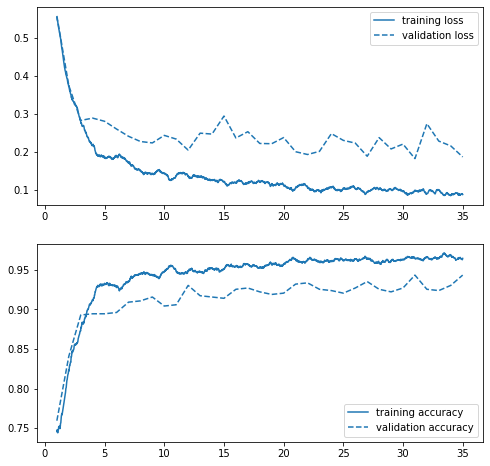

In [6]:
# Train infected vs. normal model
criterion = F.binary_cross_entropy
optimizer = optim.Adam(model_infected.parameters(), lr=0.001)

history = utils.train_model(
    model_infected, criterion, optimizer,
    lung_loaders['infected']['train'],
    lung_loaders['infected']['test'],
    epochs=35,
    device=device
)
utils.plot_history(history)

In [7]:
# Load pretrained weights for infected vs. normal model
utils.load_model(model_infected, './checkpoint_infected.pth')
pass

accuracy: 94.47%

            recall  precisions        f1
normal    0.884615    0.967290  0.924107
infected  0.981627    0.932668  0.956522



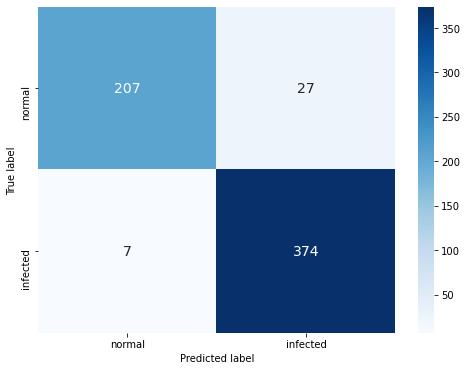

In [8]:
# Plot confusion matrix
utils.plot_confusion_matrix(
    model_infected,
    lung_loaders['infected']['test'],
    lung_datasets['infected']['test'].classes,
    device=device)

### COVID vs. Non-COVID

In [9]:
# Define COVID vs. non-COVID model
model_covid = model_utils.NetCovid().to(device)
torchsummary.summary(model_covid, (batch_size, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 150, 150]               2
            Conv2d-2         [-1, 24, 150, 150]             240
            Conv2d-3         [-1, 64, 150, 150]          13,888
            Conv2d-4           [-1, 64, 50, 50]          36,928
            Conv2d-5           [-1, 64, 50, 50]          36,928
     ResidualBlock-6           [-1, 64, 50, 50]               0
            Conv2d-7           [-1, 64, 25, 25]          36,928
            Conv2d-8           [-1, 64, 25, 25]          36,928
     ResidualBlock-9           [-1, 64, 25, 25]               0
           Conv2d-10           [-1, 64, 12, 12]          36,928
           Conv2d-11           [-1, 64, 12, 12]          36,928
    ResidualBlock-12           [-1, 64, 12, 12]               0
           Conv2d-13             [-1, 64, 6, 6]          36,928
           Conv2d-14             [-1, 6

Epoch: 1/25 @ 2021-03-21 14:27:07.180346
61/61 [==============================] - 10s 164ms/step - loss: 0.657 - accuracy: 0.651 - val_loss: 0.658 - val_accuracy: 0.635 - saved to checkpoints\2021-03-21_14-27\ckpt_00.pth
Epoch: 2/25 @ 2021-03-21 14:27:17.184353
61/61 [==============================] - 10s 159ms/step - loss: 0.635 - accuracy: 0.656 - val_loss: 0.614 - val_accuracy: 0.635 - saved to checkpoints\2021-03-21_14-27\ckpt_01.pth
Epoch: 3/25 @ 2021-03-21 14:27:26.859858
61/61 [==============================] - 10s 161ms/step - loss: 0.617 - accuracy: 0.679 - val_loss: 0.532 - val_accuracy: 0.845 - saved to checkpoints\2021-03-21_14-27\ckpt_02.pth
Epoch: 4/25 @ 2021-03-21 14:27:36.678858
61/61 [==============================] - 10s 160ms/step - loss: 0.591 - accuracy: 0.705 - val_loss: 0.434 - val_accuracy: 0.853 - saved to checkpoints\2021-03-21_14-27\ckpt_03.pth
Epoch: 5/25 @ 2021-03-21 14:27:46.468856
61/61 [==============================] - 10s 159ms/step - loss: 0.567 - acc

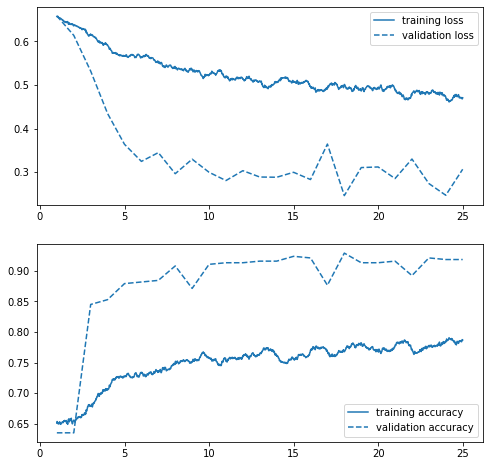

In [10]:
# Train COVID vs. non-COVID model
criterion = F.binary_cross_entropy
optimizer = optim.Adam(model_covid.parameters(), lr=0.001)

history = utils.train_model(
    model_covid, criterion, optimizer,
    lung_loaders['covid']['train'],
    lung_loaders['covid']['test'],
    epochs=25,
    device=device
)
utils.plot_history(history)

In [11]:
# Load pretrained weights for COVID vs. non-COVID model
utils.load_model(model_covid, './checkpoint_covid.pth')
pass

accuracy: 92.39%

             recall  precisions        f1
non-covid  0.966942    0.917647  0.941650
covid      0.848921    0.936508  0.890566



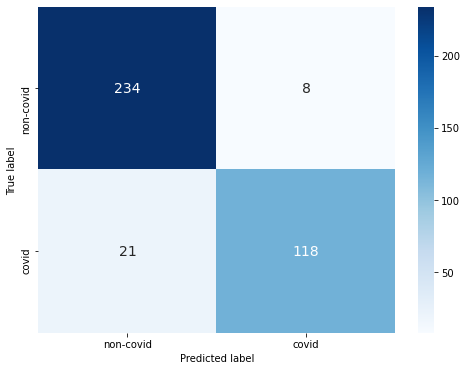

In [12]:
# Plot confusion matrix
utils.plot_confusion_matrix(
    model_covid,
    lung_loaders['covid']['test'],
    lung_datasets['covid']['test'].classes,
    device=device)

### Cascade Model

In [13]:
# Define cascade model
class CascadeModel(nn.Module):
    def forward(self, x):
        assert not self.training
        out1 = (model_infected(x) > 0.5) * 1.0
        out2 = model_covid(x)
        result = torch.cat((
            (1.0-out1).view(-1, 1),
            (out1*(1.0-out2)).view(-1, 1),
            (out1*out2).view(-1, 1)
        ), 1)
        return result


model = CascadeModel()

## Test

accuracy: 90.08%

             recall  precisions        f1
normal     0.884615    0.967290  0.924107
non-covid  0.950413    0.905512  0.927419
covid      0.841727    0.795918  0.818182



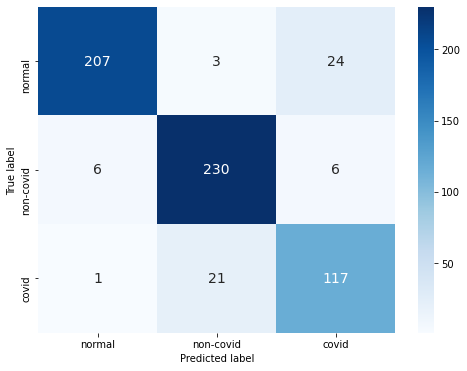

In [14]:
# Visualize model performance with confusion matrix
utils.plot_confusion_matrix(
    model,
    lung_loaders['3-classes']['test'],
    lung_datasets['3-classes']['test'].classes,
    device=device)


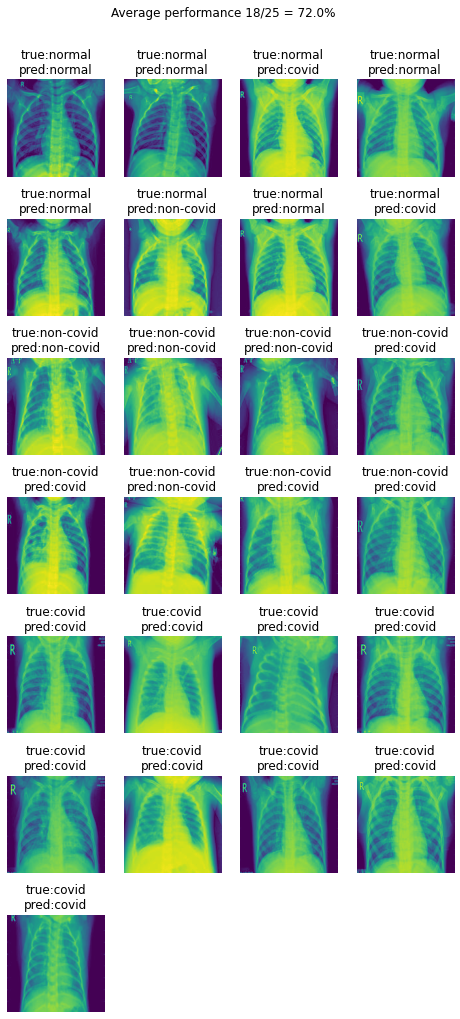

In [15]:
# Visualize model results on valiation set
utils.plot_test_results(
    model,
    lung_loaders['3-classes']['val'],
    lung_datasets['3-classes']['val'].classes,
    device=device)


## Model Visualization

Original image (true: covid pred: non-covid)


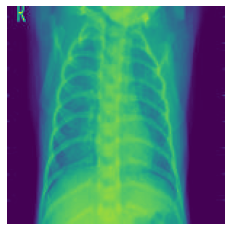

Layer 1


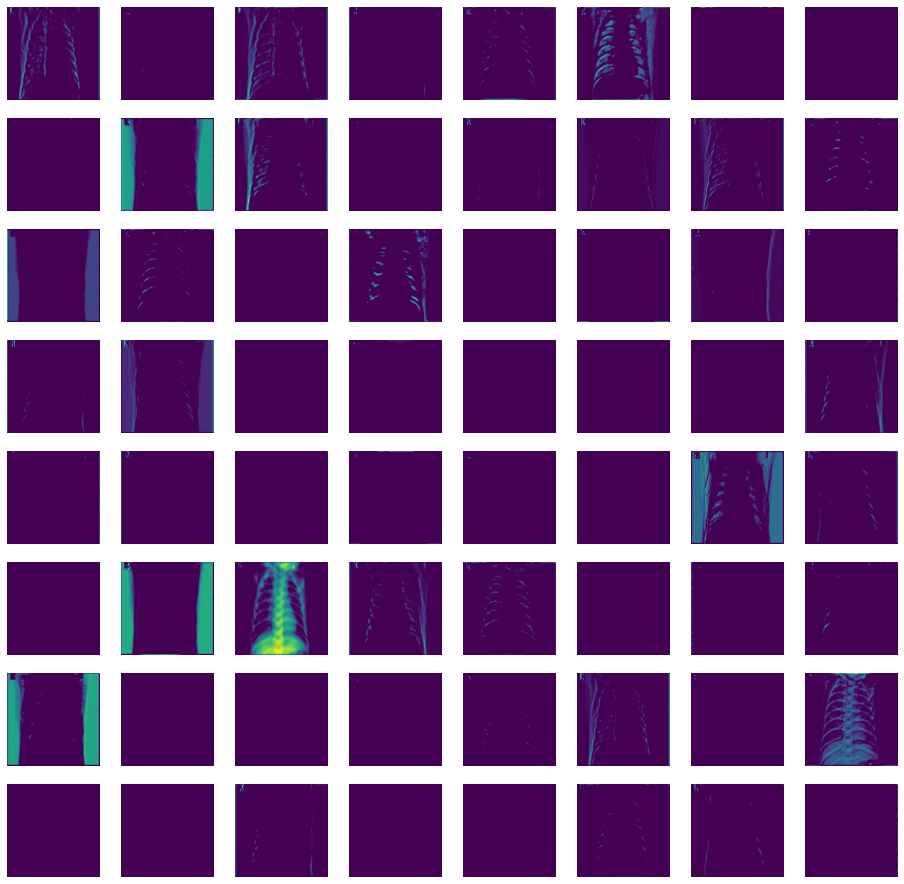

Layer 2


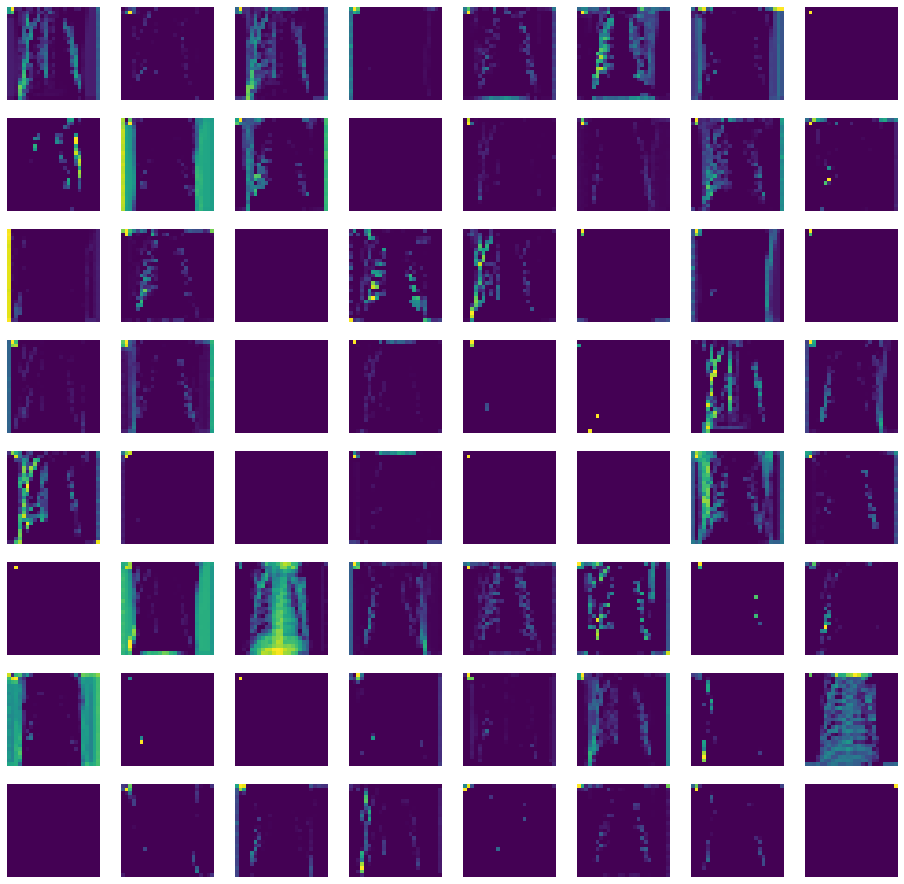

Layer 3


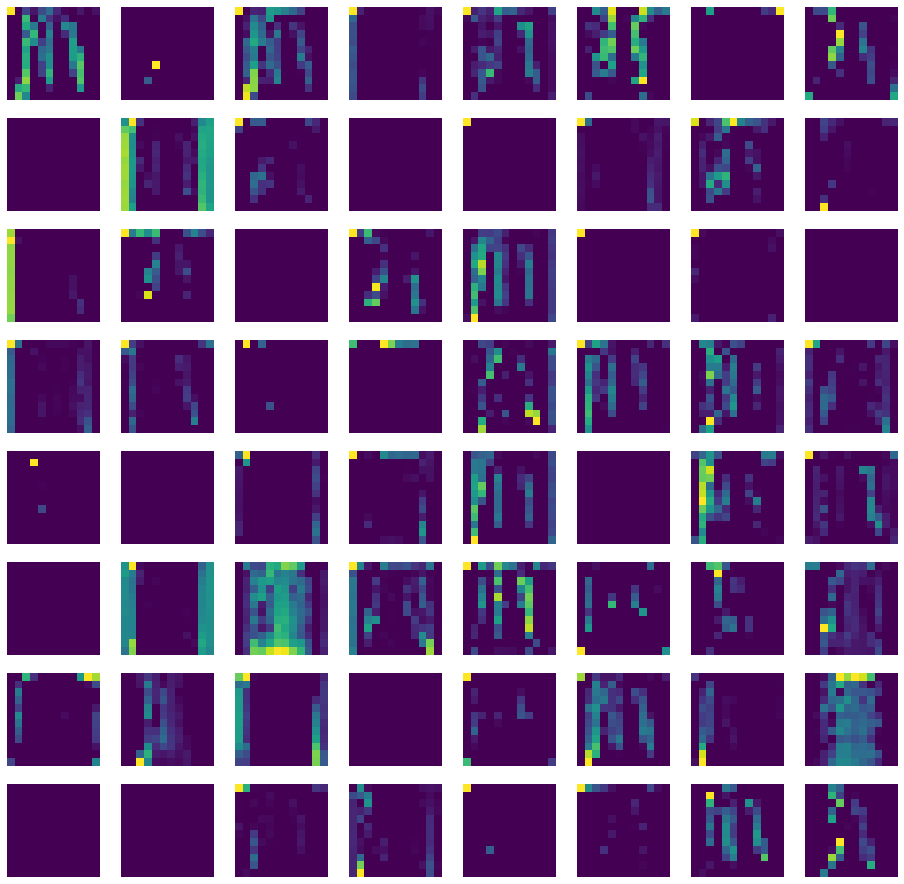

Layer 4


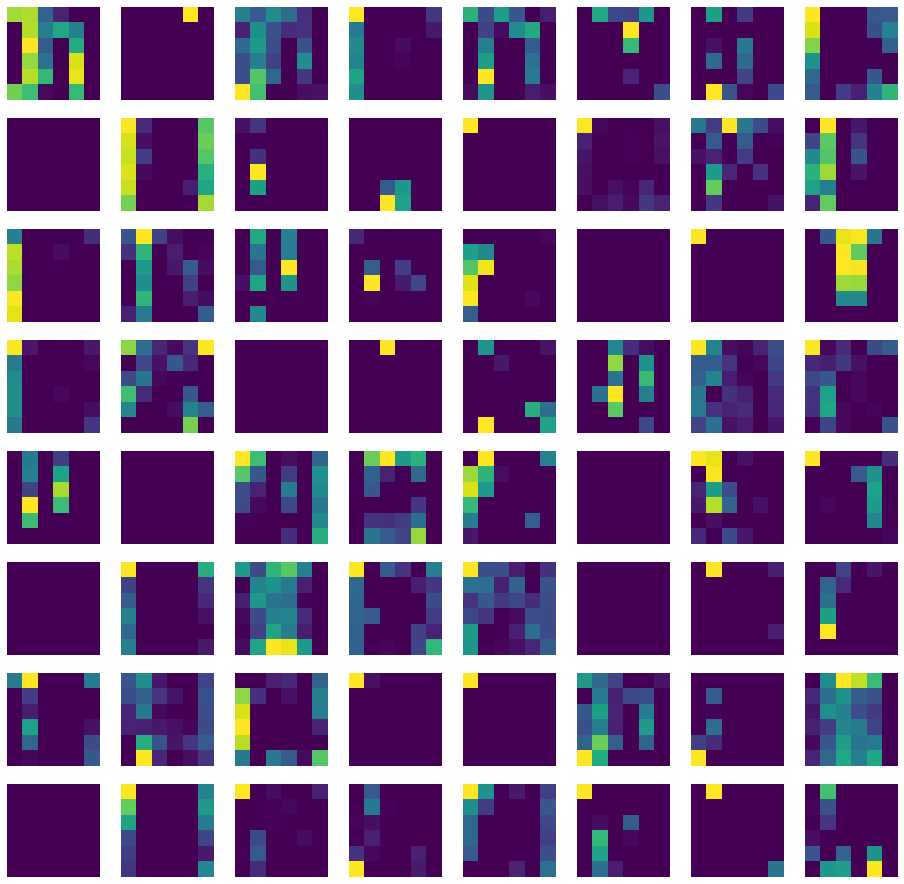

In [16]:
# Feature map visualizarion
model_covid_visual = model_utils.NetCovidVisual(model_covid).to(device)
utils.visualize_model_feature_maps(
    model_covid_visual,
    lung_loaders['3-classes']['val'],
    lung_datasets['3-classes']['val'].classes,
    device=device)
